<a href="https://colab.research.google.com/github/cosmina98/PhD/blob/main/Work_in_progress/Graph_Sage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [11]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install plotnine --quiet
!pip install torch_geometric
! install torch_geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
install: missing destination file operand after 'torch_geometric'
Try 'install --help' for more information.


In [7]:
import torch_geometric
from torch_geometric.datasets import Planetoid
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

In [ ]:
import torch_geometric 
from typing import Callable, List, Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch import Tensor
from torch.optim import Optimizer
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv,ChebConv
#from torch_geometric.utils import accuracy
from typing_extensions import Literal, TypedDict
from torch_geometric.utils import get_laplacian
import numpy as np
import pandas as pd
from plotnine import ggplot, geom_line, aes, xlab, theme, element_blank, ggtitle
import scipy.sparse as sparse
from sklearn.model_selection import KFold
from torch_geometric.utils import to_scipy_sparse_matrix
from dataclasses import dataclas

In [20]:
# libary imports 
import os
import torch
from torch import nn
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm

import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time
import pandas as pd

import itertools
from functools import reduce
import operator
import torch.utils.data as data_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from torch.utils.data import Subset

from torch.optim.adadelta import Adadelta
from torch.optim.adagrad import Adagrad
from torch.optim.adam import Adam
from torch.optim.adamax import Adamax
from torch.optim.adamw import AdamW
from torch.optim.optimizer import Optimizer
from torch.optim.sgd import SGD

import torch_geometric 
from typing import Callable, List, Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch import Tensor
from torch.optim import Optimizer
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv,ChebConv
from typing_extensions import Literal, TypedDict
from torch_geometric.utils import get_laplacian
import numpy as np
import pandas as pd
from plotnine import ggplot, geom_line, aes, xlab, theme, element_blank, ggtitle
import scipy.sparse as sparse
from sklearn.model_selection import KFold
from torch_geometric.utils import to_scipy_sparse_matrix
from dataclasses import dataclass
import torch_geometric.utils
#from torch_geometric.utils import accuracy


In [13]:
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')


#Dataset imports

In [21]:
dataset=list(range(3))
i=0
for dataset_name in ['Cora','CiteSeer','PubMed']:
    dataset[i] = Planetoid('/tmp/dataset_name', name=dataset_name)
    num_nodes = dataset[i].data.num_nodes
    num_edges = dataset[i].data.num_edges // 2
    train_len = dataset[i][0].train_mask.sum()
    val_len = dataset[i][0].val_mask.sum()
    test_len = dataset[i][0].test_mask.sum()
    other_len = num_nodes - train_len - val_len - test_len
    print(f"Dataset: {dataset[i].name}")
    print(f"Num. nodes: {num_nodes} (train={train_len}, val={val_len}, test={test_len}, other={other_len})")
    print(f"Num. edges: {num_edges}")
    print(f"Num. node features: {dataset[i].num_node_features}")
    print(f"Num. classes: {dataset[i].num_classes}")
    print(f"Dataset len.: {dataset[i].len()}")
    i=i+1
    print(" ")


Dataset: Cora
Num. nodes: 2708 (train=140, val=500, test=1000, other=1068)
Num. edges: 5278
Num. node features: 1433
Num. classes: 7
Dataset len.: 1
 
Dataset: CiteSeer
Num. nodes: 3327 (train=120, val=500, test=1000, other=1707)
Num. edges: 4552
Num. node features: 3703
Num. classes: 6
Dataset len.: 1
 
Dataset: PubMed
Num. nodes: 19717 (train=60, val=500, test=1000, other=18157)
Num. edges: 44324
Num. node features: 500
Num. classes: 3
Dataset len.: 1
 


# Training and testing targets for each dataset

In [71]:
d={0:{}, 1:{}, 2:{}}
for i in range(3):
    data=dataset[i]
    X_train=data[0].x[data[0].train_mask]
    d[i]['X_train']=X_train
    y_train=data[0].y[data[0].train_mask]
    d[i]['y_train']=y_train
    X_test=data[0].x[data[0].test_mask]
    d[i]['X_test']=X_test
    y_test=data[0].y[data[0].test_mask]
    d[i]['y_test']=y_test
    X_val=data[0].x[data[0].val_mask]
    d[i]['X_val']=X_val
    y_val=data[0].y[data[0].val_mask]
    d[i]['y_val']=X_val


#The model

In [72]:
class Net(torch.nn.Module):
    def __init__(self,
        num_node_features:int,
        num_classes:int):
      
        super(Net, self).__init__()
        self.conv = SAGEConv(num_node_features,
                             num_classes,
                             aggr="max") # max, mean, add ...)

    def forward(self, x:Tensor, edge_index: Tensor):
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

      

In [73]:
print(Net(dataset[0].num_node_features, dataset[0].num_classes))
print(Net(dataset[1].num_node_features, dataset[1].num_classes))
print(Net(dataset[2].num_node_features, dataset[2].num_classes))


Net(
  (conv): SAGEConv(1433, 7, aggr=max)
)
Net(
  (conv): SAGEConv(3703, 6, aggr=max)
)
Net(
  (conv): SAGEConv(500, 3, aggr=max)
)


#Train and eval steps

In [74]:
# we reb not using the original implementation of he framework 
# in fact we re using the model provided by Pytorch
LossFn= Callable[[Tensor, Tensor], Tensor]
Stage= Literal["train", "val", "test"]

def train_step(
    model: torch.nn.Module, data:Data, optimizer: torch.optim.Optimizer, loss_fn:LossFn)-> Tuple[float, float]:
    model.train()
    optimizer.zero_grad()
    mask=data.train_mask
    logits=model(data.x, data.edge_index)[mask]
    preds=logits.argmax(dim=1)
    y=data.y[mask]
    loss= loss_fn(logits, y)
    acc=accuracy_score(preds, y)
    loss.backward()
    optimizer.step()
    return loss.item(), acc


@torch.no_grad()
def eval_step(model:torch.nn.Module, data:Data, loss_fn:LossFn, stage:Stage)-> Tuple[float, float]:
    model.eval()
    mask=getattr(data, f"{stage}_mask")
    logits=model(data.x, data.edge_index)[mask]
    preds=logits.argmax(dim=1)
    y=data.y[mask]
    loss=loss_fn(logits, y)
    acc=accuracy_score(preds, y)
    return loss.item(), acc 

In [76]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]

def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    verbose: bool = True,
) -> HistoryDict:
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": [],"test_acc":[],"test_loss":[]}
    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        # The official implementation in TensorFlow is a little different from what is described in the paper...
        if epoch > early_stopping and val_loss > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")

    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)
    return history
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

In [77]:
SEED = 42
MAX_EPOCHS = 200
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
EARLY_STOPPING = 10

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net(dataset[0].num_node_features, dataset[0].num_classes)
data = dataset[0][0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model2 = Net(dataset[1].num_node_features, dataset[1].num_classes).to(device)
data2 = dataset[1][0].to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history2 = train(model2, data2, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model3 = Net(dataset[2].num_node_features, dataset[2].num_classes).to(device)
data3 = dataset[2][0].to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history3= train(model3, data3, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)


Epoch: 0
----------
Train loss: 1.9513 | Train acc: 0.1500
  Val loss: 1.7533 |   Val acc: 0.4380

Epoch: 20
----------
Train loss: 0.0067 | Train acc: 1.0000
  Val loss: 0.9295 |   Val acc: 0.7080

Epoch: 40
----------
Train loss: 0.0022 | Train acc: 1.0000
  Val loss: 0.9234 |   Val acc: 0.7160

Epoch: 60
----------
Train loss: 0.0027 | Train acc: 1.0000
  Val loss: 0.9148 |   Val acc: 0.7200

Epoch: 80
----------
Train loss: 0.0039 | Train acc: 1.0000
  Val loss: 0.9072 |   Val acc: 0.7280

Early stopping...

Epoch: 100
----------
Train loss: 0.0053 | Train acc: 1.0000
  Val loss: 0.9052 |   Val acc: 0.7300
 Test loss: 0.8859 |  Test acc: 0.7210

Epoch: 0
----------
Train loss: 1.7928 | Train acc: 0.2333
  Val loss: 1.5872 |   Val acc: 0.5060

Early stopping...

Epoch: 16
----------
Train loss: 0.0013 | Train acc: 1.0000
  Val loss: 1.1850 |   Val acc: 0.6120
 Test loss: 1.1368 |  Test acc: 0.6120

Epoch: 0
----------
Train loss: 1.1012 | Train acc: 0.2667
  Val loss: 1.0843 |   Va

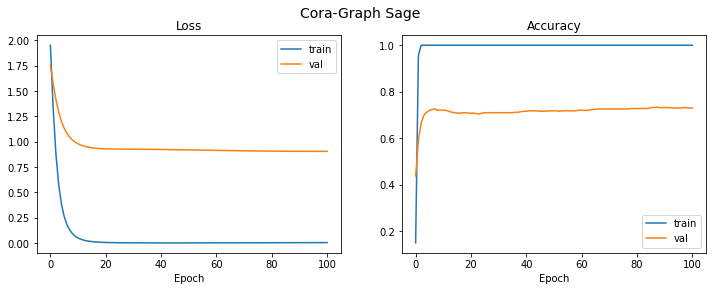

In [60]:
plt.figure(figsize=(12, 4))
plot_history(history, "Cora-Graph Sage")


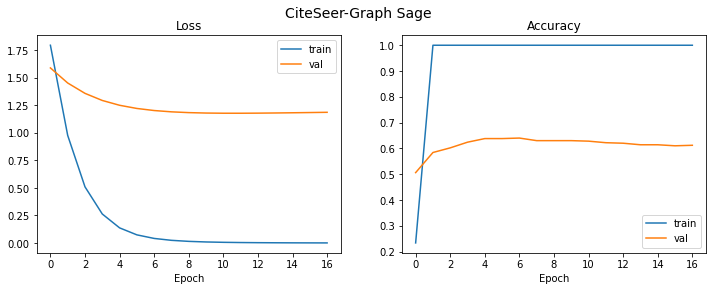

In [61]:
plt.figure(figsize=(12, 4))
plot_history(history2, "CiteSeer-Graph Sage ")

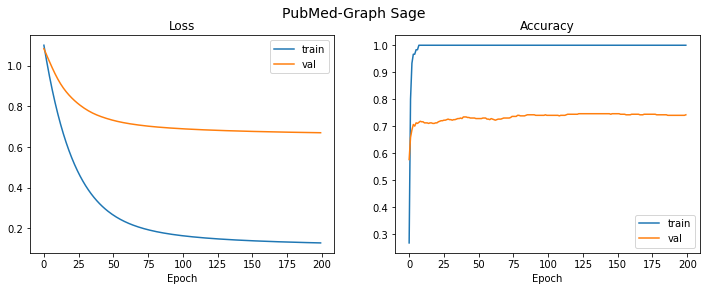

In [62]:
plt.figure(figsize=(12, 4))
plot_history(history3, "PubMed-Graph Sage")